In [24]:
# Move imports to utility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, random, math 
from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import librosa
import librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

NOTE
- See if imports, along with preprocessingg and augmentation funcs can easily be moved to the utility folder


In [2]:
class Config:
    SEED = 42
    SAMPLE_RATE = 32000
    DATA_PATH = Path("/kaggle/input/birdclef-2025")
    # Spectrogram Params
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512
    FMIN = 50
    FMAX = 14000
    # Clip params (setting for 5s to align with submission policy)
    TARGET_DURATION_S = 5
    TARGET_SAMPLES = TARGET_DURATION_S * SAMPLE_RATE
    # Path for training audio
    TRAIN_AUDIO_PATH = DATA_PATH/"train_audio"
    TRAIN_METADATA_PATH = DATA_PATH/"train.csv"
    TAXONOMY_PATH = DATA_PATH/"taxonomy.csv"
    # additional paths here
    #TRAIN_SOUNDSCAPES_PATH = DATA_PATH/"train_soundscapes"
    #TEST_SOUNDSCAPES_PATH = DATA_PATH/"test_soundscapes"    

In [3]:
# Function to seed everything to ensure reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Change to true if input sizes are kept constant

In [4]:
# Setup 
cfg = Config()
seed_everything(cfg.SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [5]:
# Loading Taxonomy data for context
if cfg.TAXONOMY_PATH.exists():
    taxonomy_df = pd.read_csv(cfg.TAXONOMY_PATH)
    print("Taxonomy data loaded")
    print(taxonomy_df.head())
    print("\nClass distribution across taxa: ")
    print(taxonomy_df['class_name'].value_counts())
else:
    print(f"File not found at {cfg.TAXONOMY_PATH}")

Taxonomy data loaded
  primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta  

Class distribution across taxa: 
class_name
Aves        146
Amphibia     34
Insecta      17
Mammalia      9
Name: count, dtype: int64


Move to the utility file once this is tested

In [6]:
# Load the training data
train_df = pd.read_csv(cfg.DATA_PATH/"train.csv")

In [7]:
# MOVE TO UTILS
# As before, create column for durations 
if 'train_df' in globals() and not train_df.empty:
    print("Analyzing audio durations...")
    durations = []
    pbar = tqdm(train_df['filename'].tolist(), desc="Calculating durations")
    for filename in pbar:
        file_path = cfg.DATA_PATH/"train_audio"/filename
        if file_path.exists():
            try:
                # Efficient approach to get duration with loading the whole file
                info = sf.info(file_path)
                durations.append(info.duration)
            except Exception as e:
                print(f"Could not get info for {filename}: {e}") #Comment / uncomment for debugging
                durations.append(np.nan) # mark errors
        else:
            durations.append(np.nan)

Analyzing audio durations...


Calculating durations:   0%|          | 0/28564 [00:00<?, ?it/s]

In [8]:
train_df['duration'] = durations
train_df['duration'].describe()

count    28564.000000
mean        35.352463
std         50.605646
min          0.544594
25%         10.579445
50%         20.976312
75%         41.300031
max       1774.392000
Name: duration, dtype: float64

In [9]:
mel_spectrogram_tfms = T.MelSpectrogram(
    sample_rate = cfg.SAMPLE_RATE,
    n_fft = cfg.N_FFT,
    hop_length = cfg.HOP_LENGTH,
    n_mels = cfg.N_MELS,
    f_min = cfg.FMIN,
    f_max = cfg.FMAX
).to(device) # transforms are moved to the GPU

In [10]:
# Connverty power spec to DB
amp_to_db_tfms = T.AmplitudeToDB(stype='power', top_db=80).to(device) 

In [11]:
# Another one for the utility file
# Then clean up
def preprocess_audio_file(file_path: Path, target_sr=cfg.SAMPLE_RATE,
                          target_samples=cfg.TARGET_SAMPLES):
    """Loads an audio file, resamples, splits into 5s non-overlapping clips,
    and converts each clip to a Mel spectrogram tensor."""
    spectrograms = []
    try: 
        waveform, sr = torchaudio.load(file_path) #return tensor [channels, time]
        # Resample if needed
        if sr != target_sr:
            resampler = T.Resample(sr, target_sr).to(waveform.device)
            waveform = resampler(waveform)
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        # Ensure waveform is on the correct device
        waveform = waveform.to(device)
        # Calculate number of full clips
        num_samples = waveform.shape[1]
        num_clips = num_samples // target_samples

        for i in range(num_clips):
            start_sample = i * target_samples
            end_sample = start_sample + target_samples
            clip = waveform[:, start_sample:end_sample] # Keep channel dim for tfms
            # Generate Mel spectrogram with output [channel, n_mels, time]
            mel_spec = mel_spectrogram_tfms(clip) 
            # Convert to DB scale
            mel_spec_db = amp_to_db_tfms(mel_spec)
            # Squeeze channel dims -> [n_mels, time]
            spectrograms.append(mel_spec_db.squeeze(0))

        # If we want to use the remaining samples for training, then this section can be uncommented:
        # remaining_samples = num_samples % target_samples
        # if remaining_samples > 0 and end_behavior=='pad': # Example
        #    last_clip = waveform[:, num_full_clips*target_samples:]
        #    padding = target_samples - last_clip.shape[1]
        #    last_clip_padded = torch.nn.functional.pad(last_clip, (0, padding))
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")
        # return empty list on error
        return []
    return spectrograms


Preprocessing test file: 1139490/CSA36385.ogg (Label: 1139490)
Expected duration: 98.85s
Successfully generated 19 spectrogram clips.
Shape of first spectrogram tensor: torch.Size([128, 313])
Device of spectrogram tensor: cuda:0


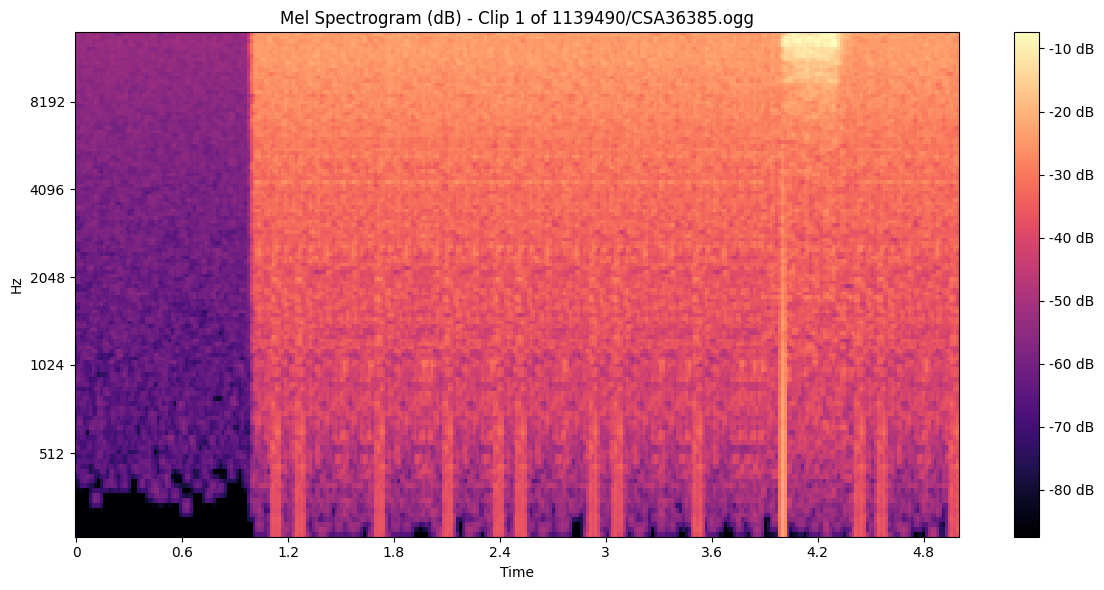

In [12]:
# Test the above function on one sample
if 'train_df' in globals() and not train_df.empty:
    # Take the first file longer than 6 seconds
    test = train_df[train_df['duration'] > 6].iloc[0]
    test_fn = test['filename']
    test_lbl = test['primary_label']
    test_path = cfg.TRAIN_AUDIO_PATH / test_fn

    print(f"\nPreprocessing test file: {test_fn} (Label: {test_lbl})")
    print(f"Expected duration: {test['duration']:.2f}s")

    if test_path.exists():
        specs = preprocess_audio_file(test_path)

        if specs:
            print(f"Successfully generated {len(specs)} spectrogram clips.")
            print(f"Shape of first spectrogram tensor: {specs[0].shape}")
            print(f"Device of spectrogram tensor: {specs[0].device}")
            # Visualize the spectrogram clip and move to CPU for plotting 
            plt.figure(figsize=(12, 6))
            spec_plt = specs[0].cpu().numpy()
            librosa.display.specshow(spec_plt, sr=cfg.SAMPLE_RATE, hop_length=cfg.HOP_LENGTH,
                                     x_axis='time', y_axis='mel', fmin=cfg.FMIN, fmax=cfg.FMAX)
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram (dB) - Clip 1 of {test_fn}")
            plt.tight_layout()
            plt.show()
        else: print("Preprocessing failed or file too short.")
    else: print(f"Test file not found: {test_path}")
else: print("train_df not available for test.")
        

Testing the `preprocess_audio_file()` function on a single sample returns 19 spectrogram clips of 5 seconds each.

Additionally, the output `torch.Size([128, 313])` confirms the Mel Spectrogram dimensions `(N_MELS=128)` and the calculated time steps for a 5 second clip with the parameters already set at the start of the NB results in `floor(16000/512) + 1 = 313 frames`. So things appear to be consistent.

The next step involves creating our core pipeline before setting up the dataloaders.

## Core Pipeline - Building a Dataset Class

Before creating a dataloader, we'll need to define a `Dataset` class that loads audio and uses the `preprocess_audio_clips` function to return pairs of spectrograms and labels which are mapped consistently.

As a first step, lets create a label encoder which maps string labels to integer indices (0-205) and back. A target label vector, in multi-label binary format, will also be needed.

In [15]:
# Create label encoder
if not train_df.empty and 'primary_label' in train_df.columns:
    u_lbl = sorted(train_df['primary_label'].unique())
    n_class = len(u_lbl)
    print(f"Found {n_class} unique primary labels.")

    # Mappings from label strings to int index and back
    lbl_2_int = {l: i for i, l in enumerate(u_lbl)}
    int_2_lbl = {i: l for l, i in lbl_2_int.items()}
    # Adding int labels to the df 
    train_df['primary_label_int'] = train_df['primary_label'].map(lbl_2_int)
    # Storing mappings in config for global access
    cfg.N_CLASSES = n_class
    cfg.LBL_2_INT = lbl_2_int
    cfg.INT_2_LBL = int_2_lbl
else: 
     print("train_df is empty or missing 'primary label'. Cannot create encoder.")
     cfg.N_CLASSES = 0     

Found 206 unique primary labels.


In [20]:
# Test look up and reverse lookup
print("Example label mappings:")
print(f"    'socfly1' -> {lbl_2_int.get('socfly1', 'Not Found')}")
print(f"    'Index 164'-> {int_2_lbl.get(164, 'Not Found')}")

Example label mappings:
    'socfly1' -> 164
    'Index 164'-> socfly1


In [21]:
# Helped function for creating the target tensor
def create_target_tensor(pri_lbl_int, n_classes):
    """Creates a multi label binary tensor for a given primary label"""
    t = torch.zeros(n_classes, dtype=torch.float32)
    if pri_lbl_int is not None and 0 <= pri_lbl_int < n_classes:
        t[pri_lbl_int] = 1.0
    return t

We will predetermine how many 5 second clips each valid audio file contains. This info can be stored to calculate the total dataset size, followed by index level mapping.

In [26]:
c_samples = []
# Filter out files shorter than the target duration
filt_df = train_df[train_df['duration'] >= cfg.TARGET_DURATION_S].copy()
print(f"Found {len(filt_df)} files >= {cfg.TARGET_DURATION_S}s duration.")

c_total = 0
for i, r in tqdm(filt_df.iterrows(), total=len(filt_df), desc="Mapping clips"):
    fname = r['filename']
    pri_lbl_int = r['primary_label_int']
    duration = r['duration']

    # Calculate the number of full 5 second clips
    n_clips = math.floor(duration / cfg.TARGET_DURATION_S)
    if n_clips > 0:
        for c_idx in range(n_clips):
            c_samples.append({
                'filename': fname,
                'primary_label_int': pri_lbl_int,
                'clip_index': c_idx
            })
        c_total += n_clips
print(f"Total number of {cfg.TARGET_DURATION_S}s clips calculated: {c_total}.")
# Convert to DF, just in case
clip_df = pd.DataFrame(c_samples)

Found 26250 files >= 5s duration.


Mapping clips:   0%|          | 0/26250 [00:00<?, ?it/s]

Total number of 5s clips calculated: 187839.


In [40]:
# Store in config
cfg.TOTAL_CLIPS = c_total

In [32]:
clip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187839 entries, 0 to 187838
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   filename           187839 non-null  object
 1   primary_label_int  187839 non-null  int64 
 2   clip_index         187839 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.3+ MB


<Axes: >

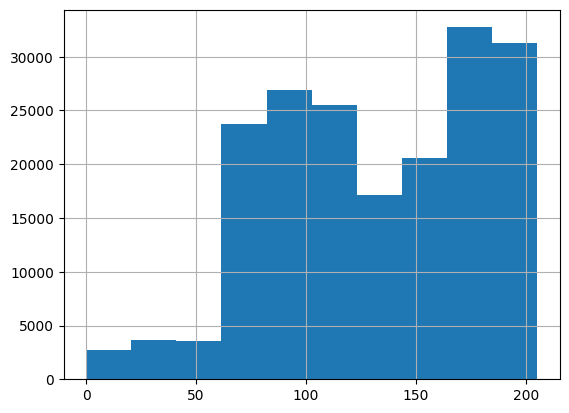

In [35]:
clip_df['primary_label_int'].hist()

In [43]:
# Creating dataset class
class BirdClefDS(Dataset):
    def __init__(self, clip_list, audio_dir, n_classes, tgt_sr=cfg.SAMPLE_RATE, tgt_samp=cfg.TARGET_SAMPLES, aug=None):
        self.clip_list = clip_list
        self.audio_dir = audio_dir
        self.n_classes = n_classes
        self.tgt_sr = tgt_sr
        self.tgt_samp = tgt_samp
        self.aug = aug

    def __len__(self):
        return len(self.clip_list)

    def __getitem__(self, idx):
        """Loads the clip by index, preprocesses it and returns spectrogram and label"""
        sample = self.clip_list[idx]
        fname = sample['filename']
        pri_lbl_int = sample['primary_label_int']
        clip_idx = sample['clip_index']

        f_path = self.audio_dir / filename
        try: # For efficiency, load only needed segments
            start_frame = clip_idx * self.tgt_samp
            n_frames = self.tgt_sample # number of frames to load
            # Load with frame offsets for speed
            wave, sr = torchaudio.load(
                f_path,
                frame_offset=start_frame,
                num_frames=n_frames
            )
            # Add pre-processing steps tested in earlier sections
            if sr != self.target_sr: # Add a robustness check
                resampler = T.Resample(sr, self.tgt_sr).to(wave.device)
                wave = resampler(wave)
            # Convert to mono
            if wave.shape[0] > 1: wave = torch.mean(wave, dim=0, keepdim=True)
            # Pad in case waveform is shorter than expected
            curr_samp = wave.shape[1]
            if curr_samp < self.tgt_samp:
                pad = self.tgt_samp - curr_samp
                wave = torch.nn.functional.pad(wave, (0, padding))
            # Truncate slightly longer files
            elif curr_samp > self.tgt_samp: wave = wave[:, :self.tgt_samp]

            wave = wave.to(device)

            # Apply transformations
            mel_spec = mel_spectrogram_tfms(wave)
            mel_spec_db = amp_to_db_tfms(mel_spec)
            # Remove channel dim
            spec = mel_spec_db.squeeze(0)
            # Apply augmentations (if any)
            if self.aug: spec = self.aug(spec)
            # Create target label
            tgt = create_target_tensor(pri_lbl_int, self.n_classes)

            return spec, tgt
        
        except Exception as e:
            print(f"Error processing clip {idx} (file: {filename}, clip_idx: {clip_idx}): {e}")
            # Return dummy data to prevent crashes which matches the expected shape
            dummy_spec = torch.zeros((cfg.N_MELS, 313), dtype=torch.float32, device=device)
            dummy_tgt = torch.zeros(self.n_classes, dtype=torch.float32)
            return dummy_spec, dummy_tgt


Created dataset with 187839 samples.

Testing __getitem__ with index: 183750
Error processing clip 183750 (file: ywcpar/iNat922688.ogg, clip_idx: 34): 'BirdClefDS' object has no attribute 'tgt_sample'
     Spectrogram shape: torch.Size([128, 313])
     Spectrogram device: cuda:0
     Target shape: torch.Size([206])
     Target sum (check for 1.0): 0.0
     Target label index: 0
     Mapped back to label: 1139490


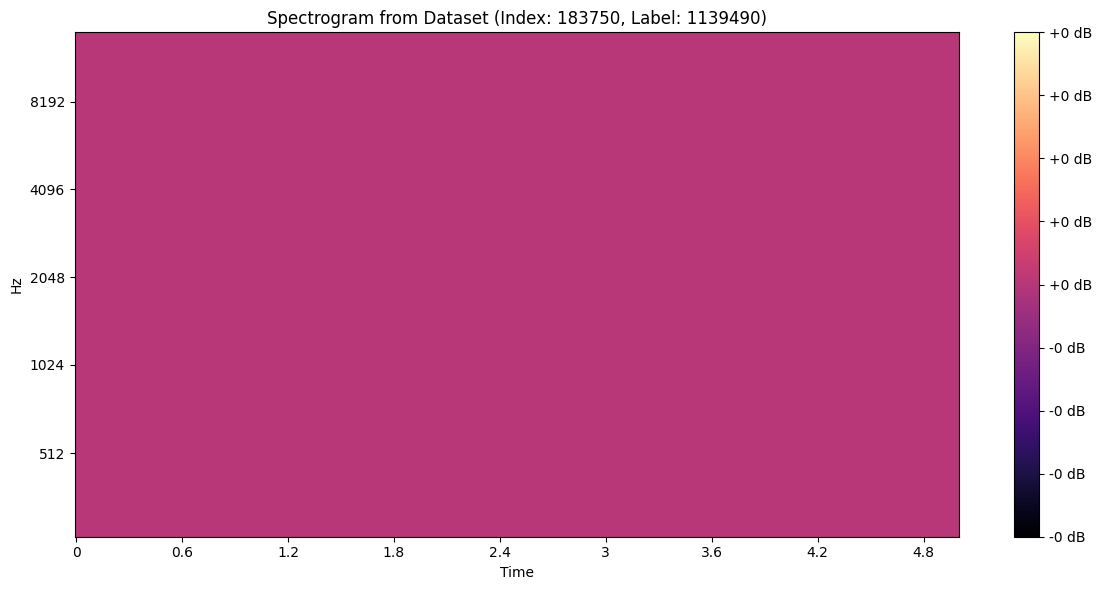


Testing __getitem__ with index: 149404
Error processing clip 149404 (file: ywcpar/iNat922688.ogg, clip_idx: 14): 'BirdClefDS' object has no attribute 'tgt_sample'
     Spectrogram shape: torch.Size([128, 313])
     Spectrogram device: cuda:0
     Target shape: torch.Size([206])
     Target sum (check for 1.0): 0.0
     Target label index: 0
     Mapped back to label: 1139490

Testing __getitem__ with index: 75820
Error processing clip 75820 (file: ywcpar/iNat922688.ogg, clip_idx: 4): 'BirdClefDS' object has no attribute 'tgt_sample'
     Spectrogram shape: torch.Size([128, 313])
     Spectrogram device: cuda:0
     Target shape: torch.Size([206])
     Target sum (check for 1.0): 0.0
     Target label index: 0
     Mapped back to label: 1139490

Testing __getitem__ with index: 144605
Error processing clip 144605 (file: ywcpar/iNat922688.ogg, clip_idx: 1): 'BirdClefDS' object has no attribute 'tgt_sample'
     Spectrogram shape: torch.Size([128, 313])
     Spectrogram device: cuda:0
   

In [47]:
# Testing the dataset class
if cfg.TOTAL_CLIPS > 0:
    bird_data = BirdClefDS(c_samples, cfg.TRAIN_AUDIO_PATH, cfg.N_CLASSES)

    print(f"\nCreated dataset with {len(bird_data)} samples.")

    # get a few items
    n_test_items = 5
    for i in range(n_test_items):
        idx = random.randint(0, len(bird_data) - 1)
        print(f"\nTesting __getitem__ with index: {idx}")
        spec, tgt = bird_data[idx]

        if spec is not None and tgt is not None:
            print(f"     Spectrogram shape: {spec.shape}")
            print(f"     Spectrogram device: {spec.device}")
            print(f"     Target shape: {tgt.shape}")
            print(f"     Target sum (check for 1.0): {tgt.sum()}")
            lbl_idx = torch.argmax(tgt).item()
            print(f"     Target label index: {lbl_idx}")
            print(f"     Mapped back to label: {cfg.INT_2_LBL.get(lbl_idx, 'Unknown')}")
            # Plot a test spectrogram
            if i == 0:
                plt.figure(figsize=(12, 6))
                librosa.display.specshow(spec.cpu().numpy(), sr=cfg.SAMPLE_RATE,
                                         hop_length=cfg.HOP_LENGTH,
                                         x_axis='time', y_axis='mel',
                                         fmin=cfg.FMIN, fmax=cfg.FMAX)
                plt.colorbar(format='%+2.0f dB')
                plt.title(f"Spectrogram from Dataset (Index: {idx}, Label: {cfg.INT_2_LBL.get(lbl_idx)})")
                plt.tight_layout()
                plt.show()
        else: print(f"     Failed to retrieve item at index {idx}.")
else: print(f"\nCannot create or test dataset because no clips were loaded / calculated.")
    

{'N_CLASSES': 206, 'LBL_2_INT': {'1139490': 0, '1192948': 1, '1194042': 2, '126247': 3, '1346504': 4, '134933': 5, '135045': 6, '1462711': 7, '1462737': 8, '1564122': 9, '21038': 10, '21116': 11, '21211': 12, '22333': 13, '22973': 14, '22976': 15, '24272': 16, '24292': 17, '24322': 18, '41663': 19, '41778': 20, '41970': 21, '42007': 22, '42087': 23, '42113': 24, '46010': 25, '47067': 26, '476537': 27, '476538': 28, '48124': 29, '50186': 30, '517119': 31, '523060': 32, '528041': 33, '52884': 34, '548639': 35, '555086': 36, '555142': 37, '566513': 38, '64862': 39, '65336': 40, '65344': 41, '65349': 42, '65373': 43, '65419': 44, '65448': 45, '65547': 46, '65962': 47, '66016': 48, '66531': 49, '66578': 50, '66893': 51, '67082': 52, '67252': 53, '714022': 54, '715170': 55, '787625': 56, '81930': 57, '868458': 58, '963335': 59, 'amakin1': 60, 'amekes': 61, 'ampkin1': 62, 'anhing': 63, 'babwar': 64, 'bafibi1': 65, 'banana': 66, 'baymac': 67, 'bbwduc': 68, 'bicwre1': 69, 'bkcdon': 70, 'bkmtou1